# 5.1 目标检测基本概念和YOLOv3设计思想

对计算机而言，能够“看到”的是图像被编码之后的数字，但它很难理解高层语义概念，比如图像或者视频帧中出现的目标是人还是物体，更无法定位目标出现在图像中哪个区域。目标检测的主要目的是让计算机可以自动识别图片或者视频帧中所有目标的类别，并在该目标周围绘制边界框，标示出每个目标的位置，如 **图1** 所示。
<br></br>
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/e25116d994724f83abe3bef7f033c1c89bf34e083075494bb7833947c557f4fc" width = "700"  div align=center" width = "800"></center>
<center><br>图1：图像分类和目标检测示意图。(a)是图像分类任务，只需识别出这是一张斑马的图片。(b)是目标检测任务，不仅要识别出这是一张斑马的图片，还要标出图中斑马的位置。</br></center>
<br></br>

## 5.1.1目标检测发展历程

在上一节中我们学习了图像分类处理基本流程，先使用卷积神经网络提取图像特征，然后再用这些特征预测分类概率，最后选出概率最大的类别，即为当前图片的类别，流程如 **图2** 所示。
<br></br>
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/183dc8e1df224df2b223f4e80b68d42c3d746f339a084c5a9f3942fba3475988" width = "800"></center>
<center><br>图2：图像分类流程示意图</br></center>
<br></br>

但对于目标检测问题，按照 **图2** 的流程则行不通。因为在图像分类任务中，对整张图提取特征的过程中没能体现出不同目标之间的区别，最终也就没法分别标示出每个物体所在的位置。

为了解决这个问题，结合图片分类任务取得的成功经验，我们可以将目标检测任务进行拆分。假设我们现在有某种方式可以在输入图片上生成一系列可能包含物体的区域，这些区域称为候选区域，在一张图上可以生成很多个候选区域。然后对每个候选区域，可以把它单独当成一幅图像来看待，使用图像分类模型对它进行分类，看它属于哪个类别或者背景（即不包含任何物体的类别）。

上一节我们学过如何解决图像分类任务，使用卷积神经网络对一幅图像进行分类不再是一件困难的事情。那么，现在问题的关键就是如何产生候选区域？比如我们可以使用穷举法来产生候选区域，如图3所示。
<br></br>
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/57755ac8e95a460f9262afc7c37a0db51f66027ff86c40e2967a2e22524c20a1" width = "800"></center>
<center><br>图3：候选区域</br></center>
<br></br>

A为图像上的某个像素点，B为A右下方另外一个像素点，A、B两点可以确定一个矩形框，记作AB。

* 如图3（a）所示：A在图片左上角位置，B遍历除A之外的所有位置，生成矩形框A1B1, …, A1Bn, …
* 如图3（b）所示：A在图片中间某个位置，B遍历A右下方所有位置，生成矩形框AkB1, …, AkBn, …

当A遍历图像上所有像素点，B则遍历它右下方所有的像素点，最终生成的矩形框集合{AiBj}将会包含图像上所有可以选择的区域。

研究员开始思考，是否可以应用传统图像算法先产生候选区域，然后再用卷积神经网络对这些区域进行分类？只要我们对每个候选区域的分类足够的准确，则一定能找到跟实际物体足够接近的区域来。穷举法也许能得到正确的预测结果，但其计算量也是非常巨大的，其所生成的总候选区域数目约为$\frac{W^2 H^2}{4}$，假设$H=W=100$，总数将会达到$2.5 \times 10^{7}$个，如此多的候选区域使得这种方法几乎没有什么实用性。但是通过这种方式，我们可以看出，假设分类任务完成的足够完美，从理论上来讲检测任务也是可以解决的，亟待解决的问题是如何设计出合适的方法来产生候选区域。需要关注两点，一个是产生候选区域的方法，另一个是提升候选区域分类效率。目标检测算法就是解决这类问题的，**图4** 给出了基于深度学习的目标检测算法，主要分为Anchor-Based和Anchor-Free，其中Anchor-Based方法又可以分为两阶段检测算法和单阶段检测算法。

<br></br>
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/485c16915ae2433d93a646b0b7576991389780b3c5204e53aed48356af74e8c3" width = "800"></center>
<center><br>图4：目标检测算法</br></center>
<br></br>

其中，Anchor(锚框)指人为预先设定好比例的一组候选框集合。

Anchor-Based使用Anchor提取候选目标框，然后在特征图上的每一个点，对Anchor进行分类和回归。两阶段检测算法先使用Anchor在图像上产生候选区域，划分前景和背景，再对候选区域进行分类并预测目标物体位置。典型的两阶段检测算法是R-CNN系列(Fast R-CNN、Faster R-CNN等)，经典的Faster R-CNN通过RPN(Region Proposal Network)学习候选区域(Region Propposal, RP)，再对候选区域进行分类和回归，输出最终目标框和类别。基于先产生候选区域再检测的两阶段模型通常具有较优的精度，但是预测速度较慢。

此外，Anchor-Based还有一些单阶段模型，这类模型在产生候选区域的同时即可预测出物体类别和位置，不需要分成两阶段来完成检测任务。典型的单阶段算法是YOLO系列(YOLOV2、YOLOv3、YOLOv4、PP-YOLO、PP-YOLOV2等)。单阶段算法摒弃两阶段算法中的RPN产生候选区域这一步骤，将候选区域和检测两个阶段合二为一，使得网络结构更加简单，检测速度快。

但是Anchor-Based方法在实际应用中存在一些缺点，比如：手工设计Anchor需要考虑Anchor的数量、尺寸(长宽比)；在特征图上像素点密集滑动会生成的检测框会存在大量负样本区域，就需要考虑正负样本不均衡的问题；Anchor的设计导致网络超参数变多，模型学习比较困难；更换不同的数据集需要重新调整Anchor。因此研究者提出了Anchor-Free方法，不再使用预先设定Anchor，通常通过预测目标的中心或角点，对目标进行检测。包含基于中心区域预测的方法(FCOS、CenterNet等)和基于多关键点联合表达的方法(CorNert、RepPoints等)。Anchor-Free算法不再需要设计Anchor，模型更为简单，减少模型耗时，但是精度也比Anchor-Based方法精度低。

三类算法的对比如下图所示：
<br></br>
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/ada190d940164471a0d6202aa1011f51eed709293e774e7a8fb474fb91aaffaa" width = "800"></center>
<center><br>图5：目标检测算法对比</br></center>

## 5.1.2 目标检测基础概念

在介绍目标检测算法之前，先介绍一些跟检测相关的基本概念，包括边界框、锚框、交并比、非极大值抑制等。

### 5.1.2.1 边界框（Bounding Box，BBox）

检测任务需要同时预测物体的类别和位置，因此需要引入一些跟位置相关的概念。通常使用边界框（bounding box，bbox）来表示物体的位置，边界框是正好能包含物体的矩形框，如 **图6** 所示，图中3个人分别对应3个边界框。
<br></br>
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/f581e1bfd07a414596368c9c03a1b30ea115a2e30a014be68b2c26961f5c38fa" width = "400"  div align=center"></center>
<center><br>图6：边界框</br></center>
<br></br>

通常有两种格式来表示边界框的位置：

1. $xyxy$，即$(x_1, y_1, x_2, y_2)$，其中$(x_1, y_1)$是矩形框左上角的坐标，$(x_2, y_2)$是矩形框右下角的坐标。图4中3个红色矩形框用$xyxy$格式表示如下：
  
* 左：$(40.93, 141.1, 226.99, 515.73)$。
* 中：$(214.29, 325.03, 399.82, 631.37)$。
* 右：$(247.2, 131.62, 480.0, 639.32)$。
  
2. $xywh$，即$(x, y, w, h)$，其中$(x, y)$是矩形框中心点的坐标，$w$是矩形框的宽度，$h$是矩形框的高度。

在检测任务中，训练数据集的标签里会给出目标物体真实边界框所对应的$(x_1, y_1, x_2, y_2)$，这样的边界框也被称为真实框（ground truth box），如 **图5** 所示，图中画出了3个人像所对应的真实框。模型会对目标物体可能出现的位置进行预测，由模型预测出的边界框则称为预测框（prediction box）。

------

**注意：**

1. 在阅读代码时，请注意使用的是哪一种格式的表示方式。
2. 图片坐标的原点在左上角，$x$轴向右为正方向，$y$轴向下为正方向。

------

要完成一项检测任务，我们通常希望模型能够根据输入的图片，输出一些预测的边界框，以及边界框中所包含的物体的类别或者说属于某个类别的概率，例如这种格式: $[L, P, x_1, y_1, x_2, y_2]$，其中$L$是类别标签，$P$是物体属于该类别的概率。一张输入图片可能会产生多个预测框，本章的核心是学习如何完成这项任务。

### 5.1.2.2 锚框（Anchor box）

锚框与物体边界框不同，是由人们假想出来的一种框。先设定好锚框的大小和形状，再以图像上某一个点为中心画出矩形框。在下图中，以像素点[300, 500]为中心可以使用下面的程序生成3个框，如运行如下代码结果图中蓝色框所示，其中锚框A1跟人像区域非常接近。

300.0 500.0 282.84271247461896 141.4213562373095
300.0 500.0 200.0 200.0
300.0 500.0 141.42135623730948 282.842712474619


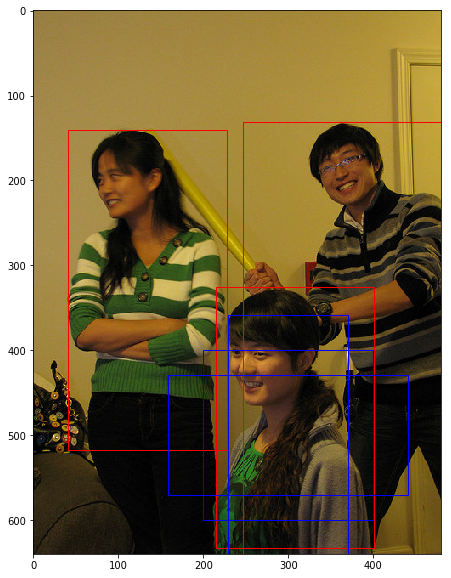

In [2]:
# 画图展示如何绘制边界框和锚框
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
from matplotlib.image import imread
import math

# 定义画矩形框的程序    
def draw_rectangle(currentAxis, bbox, edgecolor = 'k', facecolor = 'y', fill=False, linestyle='-'):
    # currentAxis，坐标轴，通过plt.gca()获取
    # bbox，边界框，包含四个数值的list， [x1, y1, x2, y2]
    # edgecolor，边框线条颜色
    # facecolor，填充颜色
    # fill, 是否填充
    # linestype，边框线型
    # patches.Rectangle需要传入左上角坐标、矩形区域的宽度、高度等参数
    rect=patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0]+1, bbox[3]-bbox[1]+1, linewidth=1,
                           edgecolor=edgecolor,facecolor=facecolor,fill=fill, linestyle=linestyle)
    currentAxis.add_patch(rect)

    
plt.figure(figsize=(10, 10))

filename = '/home/aistudio/work/images/section3/000000086956.jpg'
im = imread(filename)
plt.imshow(im)

# 使用xyxy格式表示物体真实框
bbox1 = [214.29, 325.03, 399.82, 631.37]
bbox2 = [40.93, 141.1, 226.99, 515.73]
bbox3 = [247.2, 131.62, 480.0, 639.32]

currentAxis=plt.gca()

draw_rectangle(currentAxis, bbox1, edgecolor='r')
draw_rectangle(currentAxis, bbox2, edgecolor='r')
draw_rectangle(currentAxis, bbox3,edgecolor='r')

# 绘制锚框
def draw_anchor_box(center, length, scales, ratios, img_height, img_width):
    """
    以center为中心，产生一系列锚框
    其中length指定了一个基准的长度
    scales是包含多种尺寸比例的list
    ratios是包含多种长宽比的list
    img_height和img_width是图片的尺寸，生成的锚框范围不能超出图片尺寸之外
    """
    bboxes = []
    for scale in scales:
        for ratio in ratios:
            h = length*scale*math.sqrt(ratio)
            w = length*scale/math.sqrt(ratio) 
            x1 = max(center[0] - w/2., 0.)
            y1 = max(center[1] - h/2., 0.)
            x2 = min(center[0] + w/2. - 1.0, img_width - 1.0)
            y2 = min(center[1] + h/2. - 1.0, img_height - 1.0)
            print(center[0], center[1], w, h)
            bboxes.append([x1, y1, x2, y2])

    for bbox in bboxes:
        draw_rectangle(currentAxis, bbox, edgecolor = 'b')

img_height = im.shape[0]
img_width = im.shape[1]        
draw_anchor_box([300., 500.], 100., [2.0], [0.5, 1.0, 2.0], img_height, img_width)


################# 以下为添加文字说明和箭头###############################

plt.text(285, 285, 'G1', color='red', fontsize=20)
plt.arrow(300, 288, 30, 40, color='red', width=0.001, length_includes_head=True, \
         head_width=5, head_length=10, shape='full')

plt.text(190, 320, 'A1', color='blue', fontsize=20)
plt.arrow(200, 320, 30, 40, color='blue', width=0.001, length_includes_head=True, \
         head_width=5, head_length=10, shape='full')

plt.text(160, 370, 'A2', color='blue', fontsize=20)
plt.arrow(170, 370, 30, 40, color='blue', width=0.001, length_includes_head=True, \
         head_width=5, head_length=10, shape='full')

plt.text(115, 420, 'A3', color='blue', fontsize=20)
plt.arrow(127, 420, 30, 40, color='blue', width=0.001, length_includes_head=True, \
         head_width=5, head_length=10, shape='full')

#draw_anchor_box([200., 200.], 100., [2.0], [0.5, 1.0, 2.0])    
plt.show()



在目标检测任务中，通常会以某种规则在图片上生成一系列锚框，将这些锚框当成可能的候选区域。模型对这些候选区域是否包含物体进行预测，如果包含目标物体，则还需要进一步预测出物体所属的类别。还有更为重要的一点是，由于锚框位置是固定的，它不大可能刚好跟物体边界框重合，所以需要在锚框的基础上进行微调以形成能准确描述物体位置的预测框，模型需要预测出微调的幅度。在训练过程中，模型通过学习不断的调整参数，最终能学会如何判别出锚框所代表的候选区域是否包含物体，如果包含物体的话，物体属于哪个类别，以及物体边界框相对于锚框位置需要调整的幅度。

不同的模型往往有着不同的生成锚框的方式，在后面的内容中，会详细介绍YOLOv3算法里面产生锚框的规则，理解了它的设计方案，也很容易类推到其它模型上。

### 5.1.2.3 交并比

上面我们画出了以点$(300, 500)$为中心，生成的三个锚框，我们可以看到锚框A1 与真实框 G1的重合度比较好。那么如何衡量这三个锚框跟真实框之间的关系呢？在检测任务中，使用交并比（Intersection of Union，IoU）作为衡量指标。这一概念来源于数学中的集合，用来描述两个集合$A$和$B$之间的关系，它等于两个集合的交集里面所包含的元素个数，除以它们的并集里面所包含的元素个数，具体计算公式如下：

$$IoU = \frac{A\cap B}{A \cup B}$$

我们将用这个概念来描述两个框之间的重合度。两个框可以看成是两个像素的集合，它们的交并比等于两个框重合部分的面积除以它们合并起来的面积。下图“交集”中青色区域是两个框的重合面积，图“并集”中蓝色区域是两个框的相并面积。用这两个面积相除即可得到它们之间的交并比，如 **图7** 所示。

<br></br>
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/c2095c01997044f8a054d676ab585f3beed4400961ea40379771a1fd6d8bf2ea" width = "500"></center>
<center><br>图7：交并比</br></center>
<br></br>


假设两个矩形框A和B的位置分别为：
$$A:  [x_{a1}, y_{a1}, x_{a2}, y_{a2}]$$

$$B:  [x_{b1}, y_{b1}, x_{b2}, y_{b2}]$$

假如位置关系如 **图8** 所示：
<br></br>
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/8abb3525989044fa8f512f82dfcd0f2f244594ff79cc4f14a900a09d464b22b8" width = "300"></center>
<center><br>图8：计算交并比</br></center>
<br></br>

如果二者有相交部分，则相交部分左上角坐标为：
$$x_1 = max(x_{a1}, x_{b1}), \ \ \ \ \ y_1 = max(y_{a1}, y_{b1})$$

相交部分右下角坐标为：
$$x_2 = min(x_{a2}, x_{b2}), \ \ \ \ \ y_2 = min(y_{a2}, y_{b2})$$

计算先交部分面积：
$$intersection = max(x_2 - x_1 + 1.0, 0) \cdot max(y_2 - y_1 + 1.0, 0)$$

矩形框A和B的面积分别是：
$$S_A = (x_{a2} - x_{a1} + 1.0) \cdot (y_{a2} - y_{a1} + 1.0)$$

$$S_B = (x_{b2} - x_{b1} + 1.0) \cdot (y_{b2} - y_{b1} + 1.0)$$

计算相并部分面积：
$$union = S_A + S_B - intersection$$

计算交并比：

$$IoU = \frac{intersection}{union}$$

------
**思考：**

两个矩形框之间的相对位置关系，除了上面的示意图之外，还有哪些可能，上面的公式能否覆盖所有的情形？

------

交并比计算程序如下：

In [11]:
# 计算IoU，矩形框的坐标形式为xyxy，这个函数会被保存在box_utils.py文件中
def box_iou_xyxy(box1, box2):
    # 获取box1左上角和右下角的坐标
    x1min, y1min, x1max, y1max = box1[0], box1[1], box1[2], box1[3]
    # 计算box1的面积
    s1 = (y1max - y1min + 1.) * (x1max - x1min + 1.)
    # 获取box2左上角和右下角的坐标
    x2min, y2min, x2max, y2max = box2[0], box2[1], box2[2], box2[3]
    # 计算box2的面积
    s2 = (y2max - y2min + 1.) * (x2max - x2min + 1.)
    
    # 计算相交矩形框的坐标
    xmin = np.maximum(x1min, x2min)
    ymin = np.maximum(y1min, y2min)
    xmax = np.minimum(x1max, x2max)
    ymax = np.minimum(y1max, y2max)
    # 计算相交矩形行的高度、宽度、面积
    inter_h = np.maximum(ymax - ymin + 1., 0.)
    inter_w = np.maximum(xmax - xmin + 1., 0.)
    intersection = inter_h * inter_w
    # 计算相并面积
    union = s1 + s2 - intersection
    # 计算交并比
    iou = intersection / union
    return iou


bbox1 = [100., 100., 200., 200.]
bbox2 = [120., 120., 220., 220.]
iou = box_iou_xyxy(bbox1, bbox2)
print('IoU is {}'.format(iou))  

IoU is 0.47402644317607107


In [12]:
# 计算IoU，矩形框的坐标形式为xywh
def box_iou_xywh(box1, box2):
    x1min, y1min = box1[0] - box1[2]/2.0, box1[1] - box1[3]/2.0
    x1max, y1max = box1[0] + box1[2]/2.0, box1[1] + box1[3]/2.0
    s1 = box1[2] * box1[3]

    x2min, y2min = box2[0] - box2[2]/2.0, box2[1] - box2[3]/2.0
    x2max, y2max = box2[0] + box2[2]/2.0, box2[1] + box2[3]/2.0
    s2 = box2[2] * box2[3]

    xmin = np.maximum(x1min, x2min)
    ymin = np.maximum(y1min, y2min)
    xmax = np.minimum(x1max, x2max)
    ymax = np.minimum(y1max, y2max)
    inter_h = np.maximum(ymax - ymin, 0.)
    inter_w = np.maximum(xmax - xmin, 0.)
    intersection = inter_h * inter_w

    union = s1 + s2 - intersection
    iou = intersection / union
    return iou

bbox1 = [100., 100., 200., 200.]
bbox2 = [120., 120., 220., 220.]
iou = box_iou_xywh(bbox1, bbox2)
print('IoU is {}'.format(iou))  

IoU is 0.6902485659655831


为了直观的展示交并比的大小跟重合程度之间的关系，**图9** 示意了不同交并比下两个框之间的相对位置关系，从 IoU = 0.95 到 IoU = 0.
<br></br>
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/52faaa317c6c4de59088de70e7ba0d478969aacffa6e40b4998a3ca9203a9ee2" width = "500"></center>
<center><br>图9：不同交并比下两个框之间相对位置示意图</br></center>
<br></br>

------
**问题：**

1. 什么情况下两个矩形框的IoU等于1？
1. 什么情况下两个矩形框的IoU等于0？

------

### 5.1.2.4 NMS

在目标检测过程中，网络对同一个目标可能会产生多个预测框。因此需要消除重叠较大的冗余预测框。具体的处理方法就是非极大值抑制（Non-maximum suppression，NMS）。假设使用模型对图片进行预测，一共输出了11个预测框及其得分，在图上画出预测框。在每个人像周围，都出现了多个预测框，需要消除冗余的预测框以得到最终的预测结果。

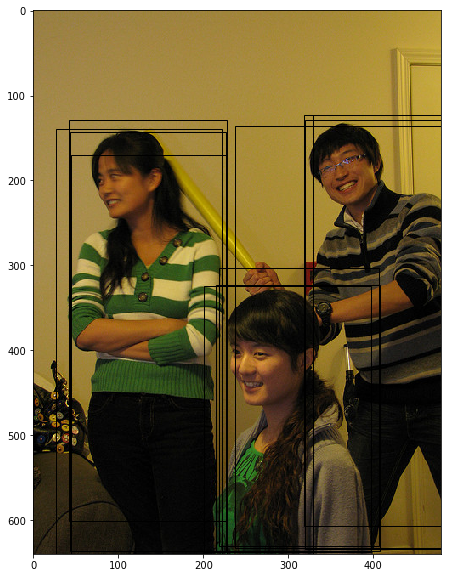

In [13]:
# 画图展示目标物体边界框
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.image import imread
import math

# 定义画矩形框的程序    
def draw_rectangle(currentAxis, bbox, edgecolor = 'k', facecolor = 'y', fill=False, linestyle='-'):
    # currentAxis，坐标轴，通过plt.gca()获取
    # bbox，边界框，包含四个数值的list， [x1, y1, x2, y2]
    # edgecolor，边框线条颜色
    # facecolor，填充颜色
    # fill, 是否填充
    # linestype，边框线型
    # patches.Rectangle需要传入左上角坐标、矩形区域的宽度、高度等参数
    rect=patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0]+1, bbox[3]-bbox[1]+1, linewidth=1,
                           edgecolor=edgecolor,facecolor=facecolor,fill=fill, linestyle=linestyle)
    currentAxis.add_patch(rect)

    
plt.figure(figsize=(10, 10))

filename = '/home/aistudio/000000086956.jpg'
im = imread(filename)
plt.imshow(im)

currentAxis=plt.gca()

# 预测框位置
boxes = np.array([[4.21716537e+01, 1.28230896e+02, 2.26547668e+02, 6.00434631e+02],
       [3.18562988e+02, 1.23168472e+02, 4.79000000e+02, 6.05688416e+02],
       [2.62704697e+01, 1.39430557e+02, 2.20587097e+02, 6.38959656e+02],
       [4.24965363e+01, 1.42706665e+02, 2.25955185e+02, 6.35671204e+02],
       [2.37462646e+02, 1.35731537e+02, 4.79000000e+02, 6.31451294e+02],
       [3.19390472e+02, 1.29295090e+02, 4.79000000e+02, 6.33003845e+02],
       [3.28933838e+02, 1.22736115e+02, 4.79000000e+02, 6.39000000e+02],
       [4.44292603e+01, 1.70438187e+02, 2.26841858e+02, 6.39000000e+02],
       [2.17988785e+02, 3.02472412e+02, 4.06062927e+02, 6.29106628e+02],
       [2.00241089e+02, 3.23755096e+02, 3.96929321e+02, 6.36386108e+02],
       [2.14310303e+02, 3.23443665e+02, 4.06732849e+02, 6.35775269e+02]])

# 预测框得分
scores = np.array([0.5247661 , 0.51759845, 0.86075854, 0.9910175 , 0.39170712,
       0.9297706 , 0.5115228 , 0.270992  , 0.19087596, 0.64201415, 0.879036])

# 画出所有预测框
for box in boxes:
    draw_rectangle(currentAxis, box)


NMS基本思想是，如果有多个预测框都对应同一个物体，则只选出得分最高的那个预测框，剩下的预测框被丢弃掉。

如何判断两个预测框对应的是同一个物体呢，标准该怎么设置？

如果两个预测框的类别一样，而且他们的位置重合度比较大，则可以认为他们是在预测同一个目标。非极大值抑制的做法是，选出某个类别得分最高的预测框，然后看哪些预测框跟它的IoU大于阈值，就把这些预测框给丢弃掉。这里IoU的阈值是超参数，需要提前设置，YOLOv3模型里面设置的是0.5。

比如在上面的程序中，boxes里面一共对应11个预测框，scores给出了它们预测"人"这一类别的得分。

- Step0：创建选中列表，keep_list = []
- Step1：对得分进行排序，remain_list = [ 3,  5, 10,  2,  9,  0,  1,  6,  4,  7,  8]， 
- Step2：选出boxes[3]，此时keep_list为空，不需要计算IoU，直接将其放入keep_list，keep_list = [3]， remain_list=[5, 10,  2,  9,  0,  1,  6,  4,  7,  8]
- Step3：选出boxes[5]，此时keep_list中已经存在boxes[3]，计算出IoU(boxes[3], boxes[5]) = 0.0，显然小于阈值，则keep_list=[3, 5], remain_list = [10,  2,  9,  0,  1,  6,  4,  7,  8]
- Step4：选出boxes[10]，此时keep_list=[3, 5]，计算IoU(boxes[3], boxes[10])=0.0268，IoU(boxes[5], boxes[10])=0.0268 = 0.24，都小于阈值，则keep_list = [3, 5, 10]，remain_list=[2,  9,  0,  1,  6,  4,  7,  8]
- Step5：选出boxes[2]，此时keep_list = [3, 5, 10]，计算IoU(boxes[3], boxes[2]) = 0.88，超过了阈值，直接将boxes[2]丢弃，keep_list=[3, 5, 10]，remain_list=[9,  0,  1,  6,  4,  7,  8]
- Step6：选出boxes[9]，此时keep_list = [3, 5, 10]，计算IoU(boxes[3], boxes[9]) = 0.0577，IoU(boxes[5], boxes[9]) = 0.205，IoU(boxes[10], boxes[9]) = 0.88，超过了阈值，将boxes[9]丢弃掉。keep_list=[3, 5, 10]，remain_list=[0,  1,  6,  4,  7,  8]
- Step7：重复上述Step6直到remain_list为空。

最终得到keep_list=[3, 5, 10]，也就是预测框3、5、10被最终挑选出来了，如下图所示。

In [14]:
# 非极大值抑制
def nms(bboxes, scores, score_thresh, nms_thresh):
    """
    nms
    """
    inds = np.argsort(scores)
    inds = inds[::-1]
    keep_inds = []
    while(len(inds) > 0):
        cur_ind = inds[0]
        cur_score = scores[cur_ind]
        # if score of the box is less than score_thresh, just drop it
        if cur_score < score_thresh:
            break

        keep = True
        for ind in keep_inds:
            current_box = bboxes[cur_ind]
            remain_box = bboxes[ind]
            iou = box_iou_xyxy(current_box, remain_box)
            if iou > nms_thresh:
                keep = False
                break
        if keep:
            keep_inds.append(cur_ind)
        inds = inds[1:]

    return np.array(keep_inds)

[ 3  5 10]


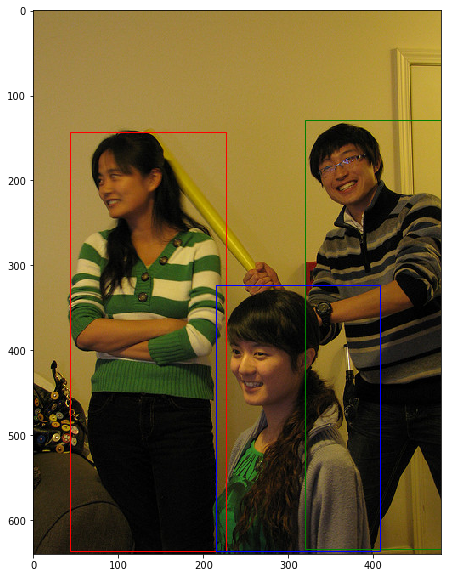

In [21]:
plt.figure(figsize=(10, 10))
plt.imshow(im)
currentAxis=plt.gca()
colors = ['r', 'g', 'b', 'k']

# 画出最终保留的预测框
inds = nms(boxes, scores, score_thresh=0.01, nms_thresh=0.5)
# 打印最终保留的预测框是哪几个
print(inds)
for i in range(len(inds)):
    box = boxes[inds[i]]
    draw_rectangle(currentAxis, box, edgecolor=colors[i])